In [1]:
import torch
import clip
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader
# from torchvision.transforms import Compose, Resize, CenterCrop, ToTensor, Normalize, ToPILImage, InterpolationMode

import pandas as pd
import os
from PIL import Image
from tqdm import tqdm
import shutil
import matplotlib.pyplot as plt
from torch.autograd import Variable
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score, roc_auc_score, roc_curve, auc
import numpy as np

import json

In [44]:
# используем cuda для распараллеливания вычислений на gpu
device = "cuda" if torch.cuda.is_available() else "cpu"
model, preprocess = clip.load('ViT-L/14', device)

In [50]:
# формируем удобный для нейросети DataFrame
base_dirs = ['/Users/kate-bor/Desktop/Neural_nets/gender_prediction/Dataset/Train', 
             '/Users/kate-bor/Desktop/Neural_nets/gender_prediction/Dataset/Validation', 
             '/Users/kate-bor/Desktop/Neural_nets/gender_prediction/Dataset/Test']
data = []

for base_dir in base_dirs:
    male_folder_path = os.path.join(base_dir, 'male')
    female_folder_path = os.path.join(base_dir, 'female')

    for filename in os.listdir(male_folder_path):
        data.append([os.path.join(male_folder_path, filename), 1, 'male', base_dir.split('/')[7]])

    for filename in os.listdir(female_folder_path):
        data.append([os.path.join(female_folder_path, filename), 0, 'female', base_dir.split('/')[7]])

df = pd.DataFrame(data, columns=['image_path', 'target_class', 'label', 'category'])
print(df.head())

                                          image_path  target_class label  \
0  /Users/kate-bor/Desktop/Neural_nets/gender_pre...             1  male   
1  /Users/kate-bor/Desktop/Neural_nets/gender_pre...             1  male   
2  /Users/kate-bor/Desktop/Neural_nets/gender_pre...             1  male   
3  /Users/kate-bor/Desktop/Neural_nets/gender_pre...             1  male   
4  /Users/kate-bor/Desktop/Neural_nets/gender_pre...             1  male   

  category  
0    Train  
1    Train  
2    Train  
3    Train  
4    Train  


In [57]:
preprocess = Compose([
    Resize(256, interpolation=3),
    CenterCrop(224),
    ToTensor(),
    Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

batch_size = 128

# добавляем в DataFrame колонку clip_features (картинка в виде числового массива) для ускорения дальнейших вычислений
def process_batch(batch):
    batch_images = torch.stack([preprocess(Image.open(path)) for path in batch['image_path']])
    batch_images = batch_images.to(device)
    with torch.no_grad():
        batch_features = model.encode_image(batch_images)
        batch_features /= batch_features.norm(dim=-1, keepdim=True)
    return batch_features

clip_features = []

for start_idx in tqdm(range(0, df.shape[0], batch_size)):
    end_idx = start_idx + batch_size
    batch = df.iloc[start_idx:end_idx]
    batch_features = process_batch(batch)
    clip_features.extend(batch_features.detach().cpu().numpy())

df['clip_features'] = clip_features

  0%|                                                                       | 1/1583 [03:18<87:01:32, 198.04s/it]


KeyboardInterrupt: 

In [192]:
# Сохранение (сделано на машине с видеокарточкой)
# df.to_json('celeba_with_clip_embeds.json', orient='records', lines=True)
# df

image_path  target_class   label category  \
0        Dataset/Train\male\000003.jpg             1    male    Train   
1        Dataset/Train\male\000007.jpg             1    male    Train   
2        Dataset/Train\male\000008.jpg             1    male    Train   
3        Dataset/Train\male\000012.jpg             1    male    Train   
4        Dataset/Train\male\000013.jpg             1    male    Train   
...                                ...           ...     ...      ...   
202594  Dataset/Test\female\179995.jpg             0  female     Test   
202595  Dataset/Test\female\179997.jpg             0  female     Test   
202596  Dataset/Test\female\179998.jpg             0  female     Test   
202597  Dataset/Test\female\179999.jpg             0  female     Test   
202598  Dataset/Test\female\180000.jpg             0  female     Test   

                                            clip_features  
0       [0.014984, 0.003716, -0.02127, 0.0186, -0.0197...  
1       [0.0608, -0.02176, -0.01607, -0.04703, -0.0432...  
2       [0.00266, -0.03305, 0.03748, -0.03445, -0.0527...  
3       [-0.003109, -0.01275, -0.01634, -0.000739, -0....  
4       [-0.02087, 0.01378, 0.04962, -0.0278, -0.03793...  
...                                                   ...  
202594  [0.02086, -0.02643, 0.01746, -0.012505, -0.017...  
202595  [-0.004227, 0.0287, -0.0333, -0.0555, 0.00865,...  
202596  [0.00503, -0.01133, 0.03558, -0.0068, 0.01292,...  
202597  [0.0198, 0.02803, 0.00308, -0.05792, -0.02835,...  
202598  [0.0695, 0.02989, 0.03656, -0.005707, 0.01049,...  

[202599 rows x 5 columns]

In [63]:
file = 'celeba_with_clip_embeds.json'
df = pd.read_json(file, orient='records', lines=True)

In [64]:
df

image_path  target_class   label category  \
0        Dataset/Train\male\000003.jpg             1    male    Train   
1        Dataset/Train\male\000007.jpg             1    male    Train   
2        Dataset/Train\male\000008.jpg             1    male    Train   
3        Dataset/Train\male\000012.jpg             1    male    Train   
4        Dataset/Train\male\000013.jpg             1    male    Train   
...                                ...           ...     ...      ...   
202594  Dataset/Test\female\179995.jpg             0  female     Test   
202595  Dataset/Test\female\179997.jpg             0  female     Test   
202596  Dataset/Test\female\179998.jpg             0  female     Test   
202597  Dataset/Test\female\179999.jpg             0  female     Test   
202598  Dataset/Test\female\180000.jpg             0  female     Test   

                                            clip_features  clip_class  
0       [0.0149841309, 0.0037155151, -0.021270752, 0.0...           1  
1       [0.060791015600000005, -0.0217590332, -0.01606...           1  
2       [0.0026607513, -0.0330505371, 0.03747558590000...           1  
3       [-0.0031089783, -0.0127487183, -0.0163421631, ...           1  
4       [-0.0208740234, 0.0137786865, 0.04962158200000...           1  
...                                                   ...         ...  
202594  [0.0208587646, -0.0264282227, 0.0174560547, -0...           0  
202595  [-0.0042266846, 0.0287017822, -0.0332946777000...           0  
202596  [0.0050315857000000005, -0.0113296509, 0.03558...           0  
202597  [0.0198059082, 0.0280303955, 0.003080368, -0.0...           0  
202598  [0.069519043, 0.029891967800000002, 0.03656005...           0  

[202599 rows x 6 columns]

In [66]:
# сохраняем вектороное представление текстов (классов гендера) 
text_labels = [
    "female",
    "male"
]
text_inputs = torch.cat([clip.tokenize(f"a photo of a {c}") for c in text_labels]).to(device)

with torch.no_grad():
    text_features = model.encode_text(text_inputs)
text_features /= text_features.norm(dim=-1, keepdim=True)
text_features = text_features.type(torch.float16)
text_features.to(device)

for index, row in tqdm(df.iterrows(), total=df.shape[0]):
    image_features = torch.tensor([row['clip_features']], dtype=torch.float16).to(device)
    similarity = (100.0 * image_features @ text_features.T).softmax(dim=-1)
    values, indices = similarity[0].topk(1)
    df.at[index, "clip_class"] = indices[0].item()

100%|██████████████████████████████████████████████████████████████████| 202599/202599 [01:17<00:00, 2609.29it/s]


In [199]:
df

image_path  target_class   label category  \
0        Dataset/Train\male\000003.jpg             1    male    Train   
1        Dataset/Train\male\000007.jpg             1    male    Train   
2        Dataset/Train\male\000008.jpg             1    male    Train   
3        Dataset/Train\male\000012.jpg             1    male    Train   
4        Dataset/Train\male\000013.jpg             1    male    Train   
...                                ...           ...     ...      ...   
202594  Dataset/Test\female\179995.jpg             0  female     Test   
202595  Dataset/Test\female\179997.jpg             0  female     Test   
202596  Dataset/Test\female\179998.jpg             0  female     Test   
202597  Dataset/Test\female\179999.jpg             0  female     Test   
202598  Dataset/Test\female\180000.jpg             0  female     Test   

                                            clip_features  clip_class  
0       [0.014984, 0.003716, -0.02127, 0.0186, -0.0197...         1.0  
1       [0.0608, -0.02176, -0.01607, -0.04703, -0.0432...         1.0  
2       [0.00266, -0.03305, 0.03748, -0.03445, -0.0527...         1.0  
3       [-0.003109, -0.01275, -0.01634, -0.000739, -0....         1.0  
4       [-0.02087, 0.01378, 0.04962, -0.0278, -0.03793...         1.0  
...                                                   ...         ...  
202594  [0.02086, -0.02643, 0.01746, -0.012505, -0.017...         0.0  
202595  [-0.004227, 0.0287, -0.0333, -0.0555, 0.00865,...         0.0  
202596  [0.00503, -0.01133, 0.03558, -0.0068, 0.01292,...         0.0  
202597  [0.0198, 0.02803, 0.00308, -0.05792, -0.02835,...         0.0  
202598  [0.0695, 0.02989, 0.03656, -0.005707, 0.01049,...         0.0  

[202599 rows x 6 columns]

In [68]:
# в каких мужчинах ошибается клип
df2 = df[(df.target_class != df.clip_class) & (df.target_class == 1)]
df2

image_path  target_class label category  \
178     Dataset/Train\male\000405.jpg             1  male    Train   
184     Dataset/Train\male\000416.jpg             1  male    Train   
185     Dataset/Train\male\000417.jpg             1  male    Train   
226     Dataset/Train\male\000520.jpg             1  male    Train   
232     Dataset/Train\male\000536.jpg             1  male    Train   
...                               ...           ...   ...      ...   
190608   Dataset/Test\male\178933.jpg             1  male     Test   
190609   Dataset/Test\male\178935.jpg             1  male     Test   
190737   Dataset/Test\male\179257.jpg             1  male     Test   
190832   Dataset/Test\male\179483.jpg             1  male     Test   
190894   Dataset/Test\male\179615.jpg             1  male     Test   

                                            clip_features  clip_class  
178     [0.0626220703, 0.0312805176, 0.006111145, -0.0...           0  
184     [0.0184173584, 0.034576416, 0.021987915, 0.012...           0  
185     [0.028167724600000003, 0.0536193848, 0.0067558...           0  
226     [-0.0033111572, 0.012336731, -0.009513855, 0.0...           0  
232     [0.0107269287, 0.0063018799000000006, -0.03671...           0  
...                                                   ...         ...  
190608  [0.0493774414, 0.0483093262, 0.043762207000000...           0  
190609  [0.0867919922, -0.0278167725, 0.0380859375, 0....           0  
190737  [-0.0379943848, 0.0172119141, 0.0429992676, -0...           0  
190832  [0.032989502000000004, -0.0089569092, 0.001733...           0  
190894  [-0.0026950836000000002, -0.0234985352, 0.0162...           0  

[1442 rows x 6 columns]

In [81]:
# Спорные случаи (клип предсказал неверно)
df_controversial = df[(df.target_class != df.clip_class) & (df.category == 'Train')]
df_controversial

image_path  target_class   label category  \
178       Dataset/Train\male\000405.jpg             1    male    Train   
184       Dataset/Train\male\000416.jpg             1    male    Train   
185       Dataset/Train\male\000417.jpg             1    male    Train   
226       Dataset/Train\male\000520.jpg             1    male    Train   
232       Dataset/Train\male\000536.jpg             1    male    Train   
...                                 ...           ...     ...      ...   
159286  Dataset/Train\female\158720.jpg             0  female    Train   
159298  Dataset/Train\female\158738.jpg             0  female    Train   
159339  Dataset/Train\female\158804.jpg             0  female    Train   
159852  Dataset/Train\female\159723.jpg             0  female    Train   
159961  Dataset/Train\female\159930.jpg             0  female    Train   

                                            clip_features  clip_class  
178     [0.0626220703, 0.0312805176, 0.006111145, -0.0...           0  
184     [0.0184173584, 0.034576416, 0.021987915, 0.012...           0  
185     [0.028167724600000003, 0.0536193848, 0.0067558...           0  
226     [-0.0033111572, 0.012336731, -0.009513855, 0.0...           0  
232     [0.0107269287, 0.0063018799000000006, -0.03671...           0  
...                                                   ...         ...  
159286  [0.0075721741000000006, 0.0202484131, 0.000220...           1  
159298  [0.0056915283, 0.0154266357, 0.0029354095, -0....           1  
159339  [0.0095443726, 0.0112686157, -0.0147247314, -0...           1  
159852  [0.0180664062, -0.0047492981, -0.0112075806000...           1  
159961  [0.0704956055, 0.022918701200000002, -0.006317...           1  

[2239 rows x 6 columns]

In [83]:
# Убираем спорные из трейна
cwd = os.getcwd() + '/'
base_dir = cwd + 'Controversial'

for index, row in df_controversial.iterrows():
    original_path = row['image_path'].replace('\\', '/')
    new_path = os.path.join(base_dir, original_path.strip('/'))

    # если пути не существует - создаем
    if not os.path.exists(os.path.dirname(new_path)):
        os.makedirs(os.path.dirname(new_path))
    
    shutil.move(cwd + original_path, new_path)

In [ ]:
# оценка качества 0-shot клипа

In [85]:
df_test = df[df.category == "Test"]

In [86]:
y_true = df_test['target_class'].values
y_pred = df_test['clip_class'].values

precision = precision_score(y_true, y_pred, average='binary')
recall = recall_score(y_true, y_pred, average='binary')
f1 = f1_score(y_true, y_pred, average='binary')
accuracy = accuracy_score(y_true, y_pred)

print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")
print(f"Accuracy: {accuracy}")

Precision: 0.9894437196062151
Recall: 0.9861685778460811
F1 Score: 0.9878034339846062
Accuracy: 0.9897005149742513


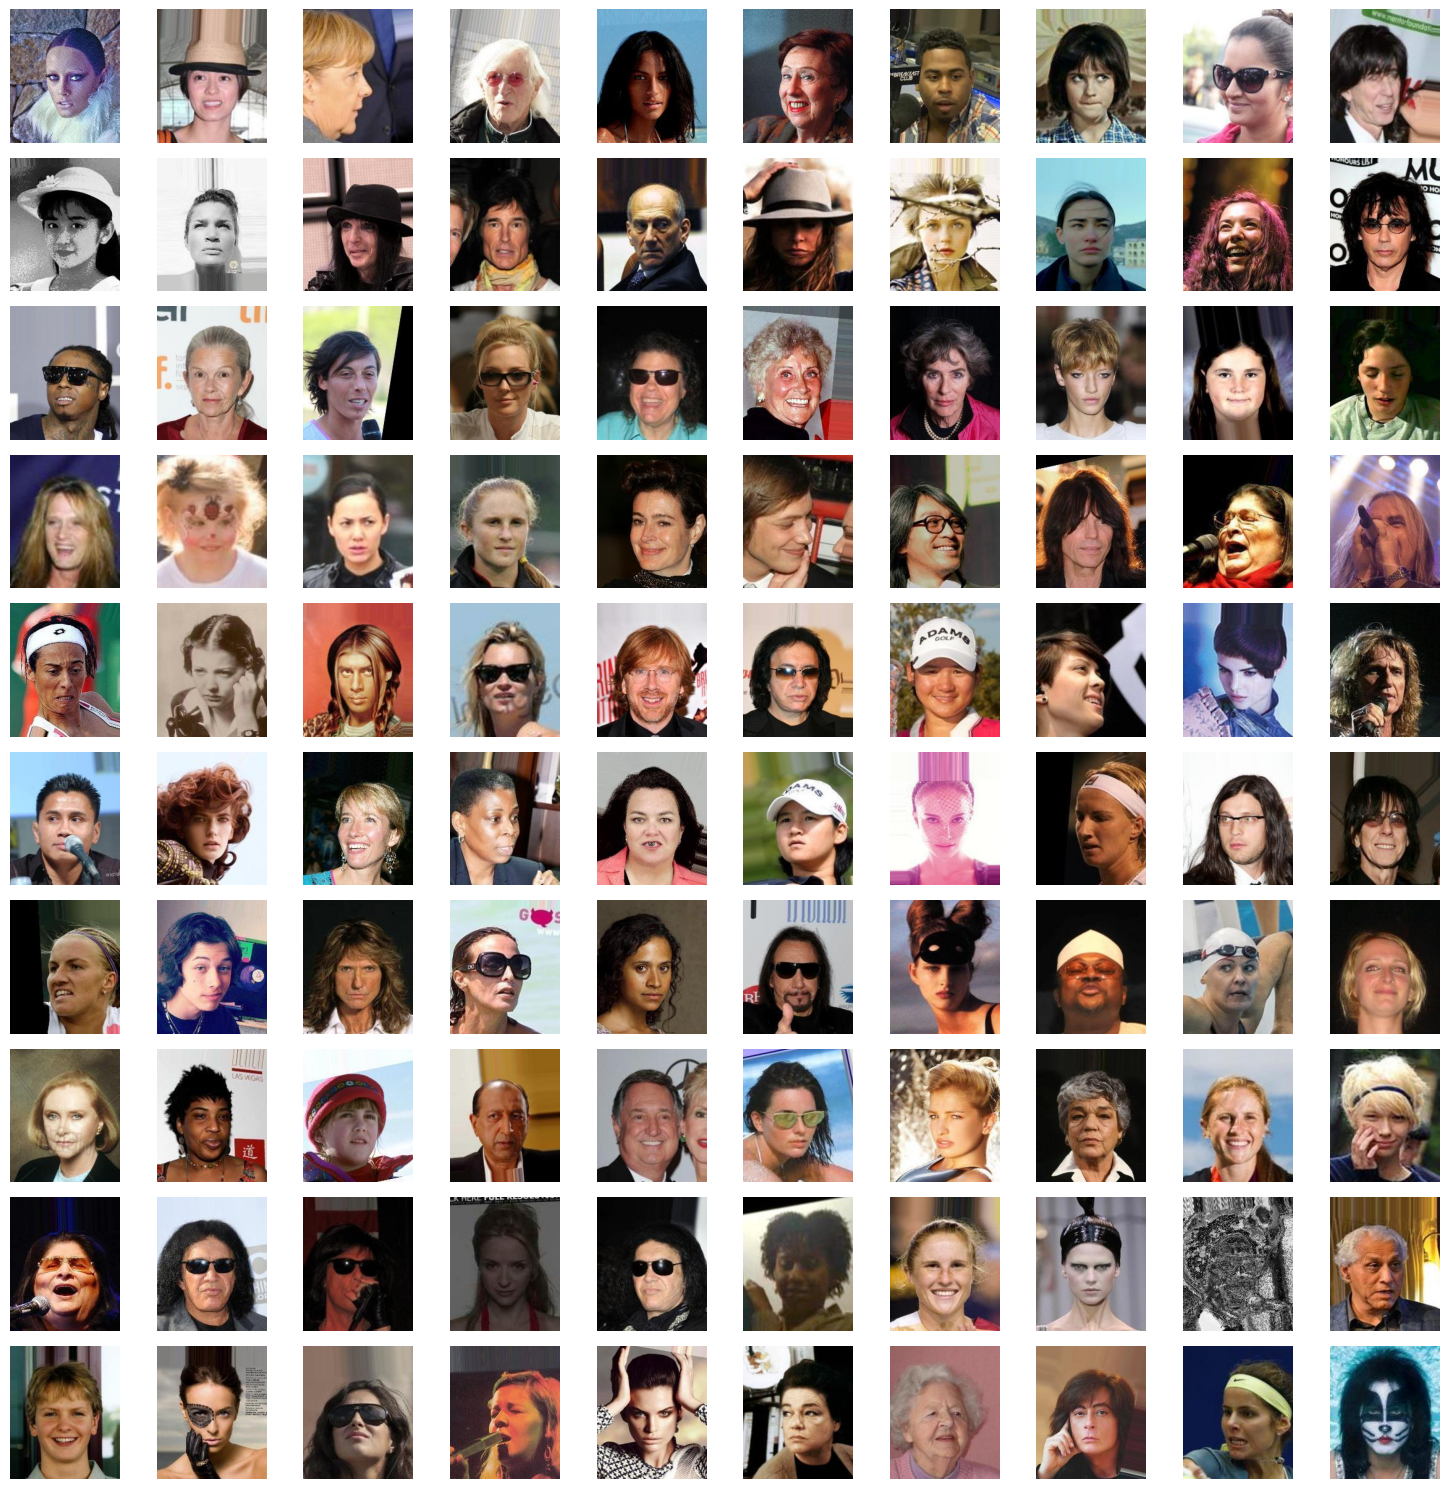

In [89]:
# Выводим ошибочные фото
num_images = min(100, len(df2))

grid_size = int(np.ceil(np.sqrt(num_images)))
fig, axes = plt.subplots(grid_size, grid_size, figsize=(15, 15))
axes = axes.flatten()

for i, (index, row) in enumerate(df2.iterrows()):
    if i >= num_images:
        break

    img = Image.open(cwd + 'Controversial/' + row['image_path'].replace('\\', '/'))
    axes[i].imshow(img)
    axes[i].axis('off')

for j in range(i + 1, len(axes)):
    axes[j].axis('off')

plt.tight_layout()
plt.show()

In [90]:
class MyDataset(Dataset):
    def __init__(self, dataframe):
        self.dataframe = dataframe

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        features = np.array(self.dataframe.iloc[idx]['clip_features'])
        target = self.dataframe.iloc[idx]['target_class']
        return torch.tensor(features, dtype=torch.float), torch.tensor(target, dtype=torch.long)

train_dataset = MyDataset(df[(df.category == "Train") & (df.target_class == df.clip_class)])
val_dataset = MyDataset(df[df.category == "Validation"])
test_dataset = MyDataset(df[df.category == "Test"])

train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=128, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False)

In [91]:
class MyModel(nn.Module):
    def __init__(self):
        super(MyModel, self).__init__()
        self.network = nn.Sequential(
            nn.Linear(768, 512),
            nn.ReLU(),      
            nn.Linear(512, 256),
            nn.ReLU(),            
            nn.Linear(256, 128), 
            nn.ReLU(),          
            nn.Linear(128, 64), 
            nn.ReLU(),   
            nn.Linear(64, 1),
        )
    
    def forward(self, x):
        return self.network(x)

In [92]:
# дообучаем голову нейронки clip
model_head = MyModel()

criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model_head.parameters(), lr=0.00001)

model_head.train()
epochs = 300 
early_stopping_patience = 5
best_val_loss = float('inf')
patience_counter = 0

for epoch in range(epochs):
    # Тренируем
    train_loss = 0.0
    for features, targets in tqdm(train_loader, desc=f'Epoch {epoch+1}/{epochs}, Training'):
        optimizer.zero_grad()
        outputs = model_head(features)
        loss = criterion(outputs.squeeze(), targets.float())
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * features.size(0)
    
    # Валидируем
    model_head.eval()
    val_loss = 0.0
    with torch.no_grad():
        for features, targets in tqdm(val_loader, desc=f'Epoch {epoch+1}/{epochs}, Validation'):
            outputs = model_head(features)
            loss = criterion(outputs.squeeze(), targets.float())
            val_loss += loss.item() * features.size(0)
    
    train_loss /= len(train_loader.dataset)
    val_loss /= len(val_loader.dataset)
    print(f'Epoch [{epoch+1}/{epochs}], Train Loss: {train_loss:.5f}, Val Loss: {val_loss:.5f}')
    
    # Прерываем обучение если 5 раз подряд loss стал хуже чем у лучшей модели
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        patience_counter = 0
        torch.save(model.state_dict(), 'best_model.pth')
    else:
        patience_counter += 1
        if patience_counter >= early_stopping_patience:
            print(f'Early stopping triggered after {epoch + 1} epochs.')
            break

    model_head.train()

model_head = MyModel()
model.load_state_dict(torch.load('best_model.pth'))
model.eval()
torch.save(model_head.state_dict(), 'model_head_weights_celeba_v3_1e-5.pth')

Epoch 1/300, Validation: 100%|█████████████████████████████████████████████████| 177/177 [00:06<00:00, 25.31it/s]


Epoch [1/300], Train Loss: 0.41668, Val Loss: 0.05867


Epoch 2/300, Validation: 100%|█████████████████████████████████████████████████| 177/177 [00:16<00:00, 10.51it/s]


Epoch [2/300], Train Loss: 0.01375, Val Loss: 0.03823


Epoch 3/300, Training:   8%|████                                               | 99/1233 [00:13<02:37,  7.18it/s]


KeyboardInterrupt: 

In [97]:
model_head = MyModel()
model_head.load_state_dict(torch.load('model_head_weights_celeba_v3_1e-5.pth'))
model_head.eval()

MyModel(
  (network): Sequential(
    (0): Linear(in_features=768, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=256, bias=True)
    (3): ReLU()
    (4): Linear(in_features=256, out_features=128, bias=True)
    (5): ReLU()
    (6): Linear(in_features=128, out_features=64, bias=True)
    (7): ReLU()
    (8): Linear(in_features=64, out_features=1, bias=True)
  )
)

In [99]:
# прогоняем через модель тестовые фотографии
model_head.eval()
all_preds = []
all_targets = []

with torch.no_grad():
    for features, targets in tqdm(test_loader):
        outputs = model_head(features)
        probabilities = torch.sigmoid(outputs).squeeze()
        predictions = (probabilities >= 0.5).long()
        all_preds.extend(predictions.cpu().numpy())
        all_targets.extend(targets.cpu().numpy())

all_preds = np.array(all_preds)
all_targets = np.array(all_targets)

# считаем точность 
accuracy = accuracy_score(all_targets, all_preds)
precision = precision_score(all_targets, all_preds)
recall = recall_score(all_targets, all_preds)
f1 = f1_score(all_targets, all_preds)

print(f'Test Accuracy: {accuracy:.4f}')
print(f'Test Precision: {precision:.4f}')
print(f'Test Recall: {recall:.4f}')
print(f'Test F1 Score: {f1:.4f}')

100%|██████████████████████████████████████████████████████████████████████████| 157/157 [00:04<00:00, 34.43it/s]


Test Accuracy: 0.9945
Test Precision: 0.9968
Test Recall: 0.9901
Test F1 Score: 0.9934


# Результаты
Видно, что обученная модель работает лучше:

In [ ]:
# Celeba CLIP
Precision: 0.9894437196062151
Recall: 0.9861685778460811
F1 Score: 0.9878034339846062
Accuracy: 0.9897005149742513

In [ ]:
# Celeba dirty (head)
Test Accuracy: 0.9936
Test Precision: 0.9945
Test Recall: 0.9903
Test F1 Score: 0.9924

In [ ]:
# Celeba clear lr=1e-5
Test Accuracy: 0.9945
Test Precision: 0.9968
Test Recall: 0.9901
Test F1 Score: 0.9934

In [100]:
model_head.eval()

# функция применения модели к набору данных для прогноза
def predict_with_model(df, model):
    predictions = []
    for index, row in tqdm(df.iterrows(), total=df.shape[0], desc="Predicting"):
        features = torch.tensor(row['clip_features'], dtype=torch.float32)
        features = features.unsqueeze(0)
        features = Variable(features, requires_grad=False)
        
        with torch.no_grad():
            output = model(features)
            prob = torch.sigmoid(output)
            predicted_class = 1 if prob >= 0.5 else 0
        predictions.append(predicted_class)
        
    return predictions

df['head_class'] = predict_with_model(df, model_head)

Predicting: 100%|██████████████████████████████████████████████████████| 202599/202599 [02:33<00:00, 1321.55it/s]


In [101]:
df[df.category == "Test"]

image_path  target_class   label category  \
182598    Dataset/Test\male\160002.jpg             1    male     Test   
182599    Dataset/Test\male\160006.jpg             1    male     Test   
182600    Dataset/Test\male\160007.jpg             1    male     Test   
182601    Dataset/Test\male\160008.jpg             1    male     Test   
182602    Dataset/Test\male\160014.jpg             1    male     Test   
...                                ...           ...     ...      ...   
202594  Dataset/Test\female\179995.jpg             0  female     Test   
202595  Dataset/Test\female\179997.jpg             0  female     Test   
202596  Dataset/Test\female\179998.jpg             0  female     Test   
202597  Dataset/Test\female\179999.jpg             0  female     Test   
202598  Dataset/Test\female\180000.jpg             0  female     Test   

                                            clip_features  clip_class  \
182598  [0.0200958252, 0.0223999023, 0.013938903800000...           1   
182599  [-0.0306243896, 0.004901886, -0.0163269043, 0....           1   
182600  [-0.0148696899, 0.0025672913000000003, 0.02011...           1   
182601  [-0.012016296400000001, 0.0083236694, 0.036132...           1   
182602  [0.0097427368, 0.0226745605, 0.0481872559, -0....           1   
...                                                   ...         ...   
202594  [0.0208587646, -0.0264282227, 0.0174560547, -0...           0   
202595  [-0.0042266846, 0.0287017822, -0.0332946777000...           0   
202596  [0.0050315857000000005, -0.0113296509, 0.03558...           0   
202597  [0.0198059082, 0.0280303955, 0.003080368, -0.0...           0   
202598  [0.069519043, 0.029891967800000002, 0.03656005...           0   

        head_class  
182598           1  
182599           1  
182600           1  
182601           1  
182602           1  
...            ...  
202594           0  
202595           0  
202596           0  
202597           0  
202598           0  

[20001 rows x 7 columns]

In [103]:
df_wrongs_clip = df[(df.category == "Test") & (df.target_class != df.clip_class) & (df.label == "male")]
df_wrongs_clip

image_path  target_class label category  \
182617  Dataset/Test\male\160046.jpg             1  male     Test   
182690  Dataset/Test\male\160253.jpg             1  male     Test   
182929  Dataset/Test\male\160863.jpg             1  male     Test   
182977  Dataset/Test\male\160977.jpg             1  male     Test   
182993  Dataset/Test\male\161009.jpg             1  male     Test   
...                              ...           ...   ...      ...   
190608  Dataset/Test\male\178933.jpg             1  male     Test   
190609  Dataset/Test\male\178935.jpg             1  male     Test   
190737  Dataset/Test\male\179257.jpg             1  male     Test   
190832  Dataset/Test\male\179483.jpg             1  male     Test   
190894  Dataset/Test\male\179615.jpg             1  male     Test   

                                            clip_features  clip_class  \
182617  [-0.0087814331, 0.045440673800000005, 0.001311...           0   
182690  [-0.0302886963, -0.0068511963, 0.0115585327, 0...           0   
182929  [0.022354126000000002, 0.0460205078, 0.0231170...           0   
182977  [0.0006475449, 0.0247650146, 0.0068664551, -0....           0   
182993  [0.0551757812, 0.0177154541, 0.0390319824, 0.0...           0   
...                                                   ...         ...   
190608  [0.0493774414, 0.0483093262, 0.043762207000000...           0   
190609  [0.0867919922, -0.0278167725, 0.0380859375, 0....           0   
190737  [-0.0379943848, 0.0172119141, 0.0429992676, -0...           0   
190832  [0.032989502000000004, -0.0089569092, 0.001733...           0   
190894  [-0.0026950836000000002, -0.0234985352, 0.0162...           0   

        head_class  
182617           0  
182690           0  
182929           0  
182977           0  
182993           0  
...            ...  
190608           0  
190609           0  
190737           1  
190832           0  
190894           0  

[117 rows x 7 columns]

In [104]:
df_wrongs = df[(df.category == "Test") & (df.target_class != df.head_class) & (df.label == "male")]
df_wrongs

image_path  target_class label category  \
182617  Dataset/Test\male\160046.jpg             1  male     Test   
182690  Dataset/Test\male\160253.jpg             1  male     Test   
182929  Dataset/Test\male\160863.jpg             1  male     Test   
182977  Dataset/Test\male\160977.jpg             1  male     Test   
182993  Dataset/Test\male\161009.jpg             1  male     Test   
...                              ...           ...   ...      ...   
190581  Dataset/Test\male\178876.jpg             1  male     Test   
190608  Dataset/Test\male\178933.jpg             1  male     Test   
190609  Dataset/Test\male\178935.jpg             1  male     Test   
190832  Dataset/Test\male\179483.jpg             1  male     Test   
190894  Dataset/Test\male\179615.jpg             1  male     Test   

                                            clip_features  clip_class  \
182617  [-0.0087814331, 0.045440673800000005, 0.001311...           0   
182690  [-0.0302886963, -0.0068511963, 0.0115585327, 0...           0   
182929  [0.022354126000000002, 0.0460205078, 0.0231170...           0   
182977  [0.0006475449, 0.0247650146, 0.0068664551, -0....           0   
182993  [0.0551757812, 0.0177154541, 0.0390319824, 0.0...           0   
...                                                   ...         ...   
190581  [0.0429077148, 0.0409851074, -0.0117874146, 0....           0   
190608  [0.0493774414, 0.0483093262, 0.043762207000000...           0   
190609  [0.0867919922, -0.0278167725, 0.0380859375, 0....           0   
190832  [0.032989502000000004, -0.0089569092, 0.001733...           0   
190894  [-0.0026950836000000002, -0.0234985352, 0.0162...           0   

        head_class  
182617           0  
182690           0  
182929           0  
182977           0  
182993           0  
...            ...  
190581           0  
190608           0  
190609           0  
190832           0  
190894           0  

[84 rows x 7 columns]

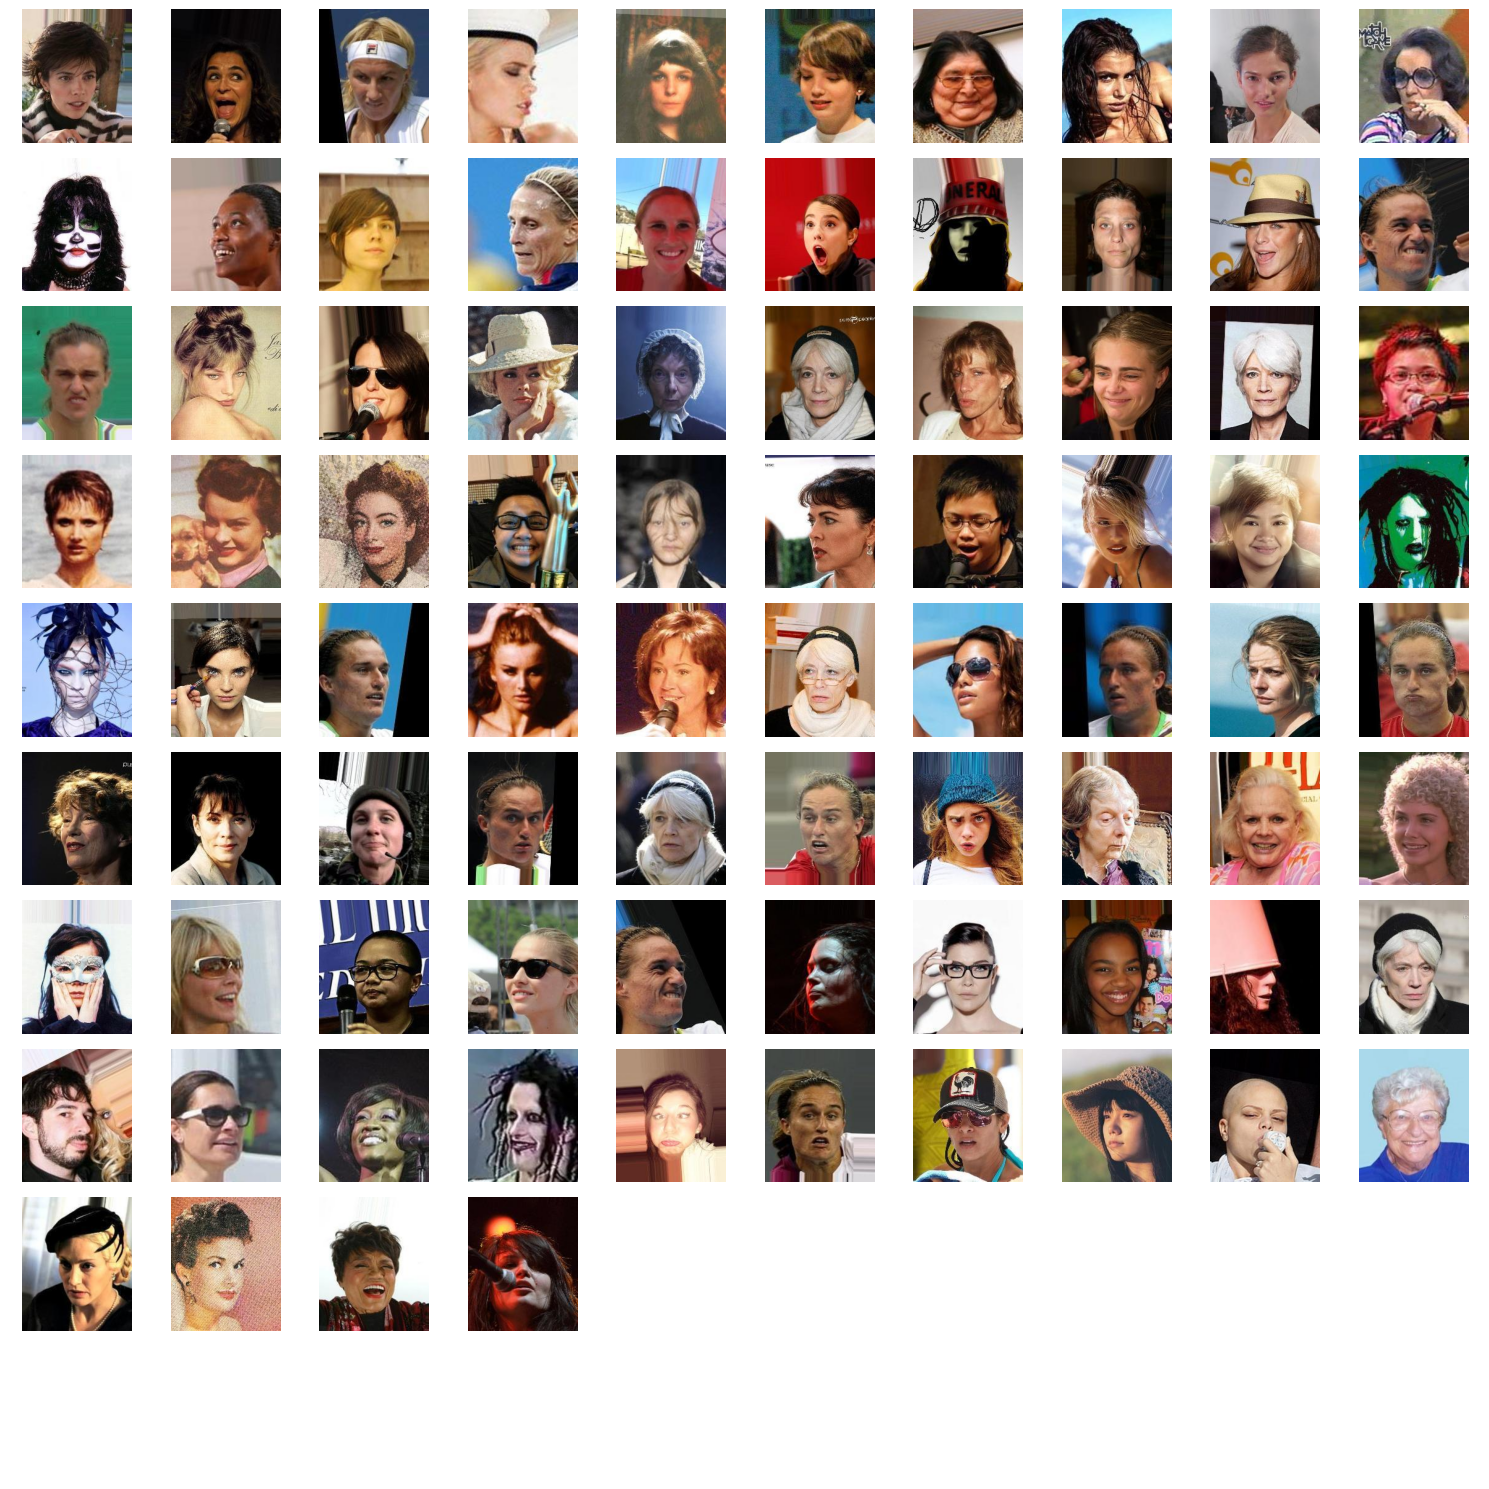

In [107]:
num_images = min(100, len(df_wrongs))

grid_size = int(np.ceil(np.sqrt(num_images)))
fig, axes = plt.subplots(grid_size, grid_size, figsize=(15, 15))
axes = axes.flatten()

for i, (index, row) in enumerate(df_wrongs.iterrows()):
    if i >= num_images:
        break
    
    img = Image.open(cwd + row['image_path'].replace('\\', '/'))
    axes[i].imshow(img)
    axes[i].axis('off')

for j in range(i + 1, len(axes)):
    axes[j].axis('off')

plt.tight_layout()
plt.show()

# Тест пайплайна

In [111]:
!pip install opencv-python

In [115]:
# Функция для распознавания биологической гендерной идентификации
def predict_gender(image):
    image_input = preprocess(image).unsqueeze(0).to(device)
    with torch.no_grad():
        image_features = model.encode_image(image_input)

    image_features /= image_features.norm(dim=-1, keepdim=True)
    image_features = image_features.to(dtype=torch.float32).unsqueeze(0).to(device)
    
    with torch.no_grad():
        output = model_head(image_features)
        
    prob = torch.sigmoid(output)
    
    return 1 if prob >= 0.5 else 0

Found 1 face(s)
female


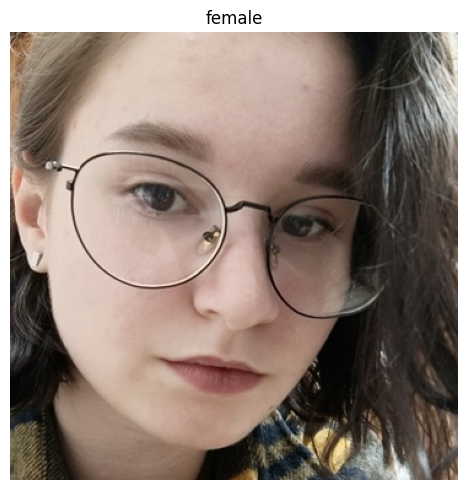

In [116]:
# Базовое распознавание лиц
from PIL import Image
import cv2 as cv

def extract_and_show_faces(image_path):
    scaleFactor = 1.1
    minNeighbors = 4
    minSize = (30, 30)

    img0 = cv.imread(image_path)
    gray = cv.cvtColor(img0, cv.COLOR_BGR2GRAY)

    path = cv.data.haarcascades + 'haarcascade_frontalface_default.xml'
    face_detector = cv.CascadeClassifier(path)

    rects = face_detector.detectMultiScale(gray, scaleFactor=scaleFactor, minNeighbors=minNeighbors, minSize=minSize, flags=cv.CASCADE_SCALE_IMAGE)
    print(f'Found {len(rects)} face(s)')

    fig, axs = plt.subplots(1, len(rects), figsize=(10, 5))
    if len(rects) == 1:
        axs = [axs]
    
    for i, (x, y, w, h) in enumerate(rects):
        face_img = img0[y:y+h, x:x+w]
        image = Image.fromarray(cv.cvtColor(face_img, cv.COLOR_BGR2RGB))

        predicted_class = predict_gender(image)
    
        print("female" if predicted_class == 0 else "male")
        
        # Plotting
        axs[i].imshow(image)
        axs[i].set_title("female" if predicted_class == 0 else "male")
        axs[i].axis('off')
    
    plt.tight_layout()
    plt.show()

image_path = '/Users/kate-bor/Desktop/gender_prediction/IHtO47cE6kuoG_5eCfG2HHX5LAR0s4XUG1NRLSfIO1BfF3GWWM7UokI_Yyu52qu_-giXRDiq8CzD8iVQE4oWHQ1eZUuShg.jpg'
extract_and_show_faces(image_path)

In [119]:
image = Image.open(image_path)
predicted_class = predict_gender(image)
predicted_class

0

# Production

In [4]:
import torch
import clip
from PIL import Image
from torch import nn

In [5]:
# используем cuda для распараллеливания вычислений на gpu
device = "cuda" if torch.cuda.is_available() else "cpu"
model, preprocess = clip.load('ViT-L/14', device)

In [6]:
class MyModel(nn.Module):
    def __init__(self):
        super(MyModel, self).__init__()
        self.network = nn.Sequential(
            nn.Linear(768, 512),  
            nn.ReLU(),            
            nn.Linear(512, 256),  
            nn.ReLU(),            
            nn.Linear(256, 128), 
            nn.ReLU(),      
            nn.Linear(128, 64),
            nn.ReLU(),           
            nn.Linear(64, 1),
        )
    
    def forward(self, x):
        return self.network(x)

In [7]:
model_head = MyModel()
model_head.load_state_dict(torch.load('model_head_weights_celeba_v3_1e-5.pth'))
model_head.eval()

MyModel(
  (network): Sequential(
    (0): Linear(in_features=768, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=256, bias=True)
    (3): ReLU()
    (4): Linear(in_features=256, out_features=128, bias=True)
    (5): ReLU()
    (6): Linear(in_features=128, out_features=64, bias=True)
    (7): ReLU()
    (8): Linear(in_features=64, out_features=1, bias=True)
  )
)

In [8]:
# Функция для распознавания биологической гендерной идентификации
def predict_gender(image):
    image_input = preprocess(image).unsqueeze(0).to(device)
    with torch.no_grad():
        image_features = model.encode_image(image_input)

    image_features /= image_features.norm(dim=-1, keepdim=True)
    image_features = image_features.to(dtype=torch.float32).unsqueeze(0).to(device)
    
    with torch.no_grad():
        output = model_head(image_features)
        
    prob = torch.sigmoid(output)
    
    return 1 if prob >= 0.5 else 0

In [9]:
image_path = image_path = '/Users/kate-bor/Desktop/gender_prediction/IHtO47cE6kuoG_5eCfG2HHX5LAR0s4XUG1NRLSfIO1BfF3GWWM7UokI_Yyu52qu_-giXRDiq8CzD8iVQE4oWHQ1eZUuShg.jpg'
image = Image.open(image_path)
predicted_class = predict_gender(image)
print("female" if predicted_class == 0 else "male")

female
